In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from tqdm.auto import tqdm 

In [2]:
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re 
from collections import Counter
from string import punctuation

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [5]:
from gensim.models import Word2Vec
!pip install torch
!pip install torchmetrics
!pip install mlxtend
import torch 
import torch.nn as nn  
from torch.optim import Adam
from torch.utils.data import DataLoader , TensorDataset
from torchmetrics import ConfusionMatrix 
from mlxtend.plotting import plot_confusion_matrix

lemma = WordNetLemmatizer()
lb = LabelEncoder()

In [6]:
#Loading dataset
twitter = pd.read_csv("F:\\Internships\\ProdigyInfotech\\twitter_training.csv")

In [7]:
twitter.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [8]:
twitter.tail()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...
74680,9200,Nvidia,Positive,Just like the windows partition of my Mac is l...


In [9]:
#check for unique values
np.unique(twitter['Borderlands'])

array(['Amazon', 'ApexLegends', 'AssassinsCreed', 'Battlefield',
       'Borderlands', 'CS-GO', 'CallOfDuty', 'CallOfDutyBlackopsColdWar',
       'Cyberpunk2077', 'Dota2', 'FIFA', 'Facebook', 'Fortnite', 'Google',
       'GrandTheftAuto(GTA)', 'Hearthstone', 'HomeDepot',
       'LeagueOfLegends', 'MaddenNFL', 'Microsoft', 'NBA2K', 'Nvidia',
       'Overwatch', 'PlayStation5(PS5)',
       'PlayerUnknownsBattlegrounds(PUBG)', 'RedDeadRedemption(RDR)',
       'TomClancysGhostRecon', 'TomClancysRainbowSix', 'Verizon',
       'WorldOfCraft', 'Xbox(Xseries)', 'johnson&johnson'], dtype=object)

In [10]:
np.unique(twitter['Positive'])

array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object)

In [11]:
#dropping unique values
twitter = twitter.drop('2401',axis=1)

In [12]:
#Rename feature columns
twitter = twitter.rename(columns={"Borderlands": "F2", "im getting on borderlands and i will murder you all ,": "F1", "Positive": "Review"})

In [13]:
twitter.head()

,F2,Review,F1
0,Borderlands,Positive,I am coming to the borders and I will kill you...
1,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,Borderlands,Positive,im coming on borderlands and i will murder you...
3,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,Borderlands,Positive,im getting into borderlands and i can murder y...


In [14]:
twitter["tweets"] = twitter["F1"].astype(str) + " " + twitter["F2"].astype(str)
twitter = twitter.drop(["F1","F2"], axis=1)

In [15]:
twitter_review = {key : value for value , key in enumerate(np.unique(twitter['Review']))}
twitter_review

{'Irrelevant': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}

In [105]:
def getlabel(n) : 
    for x , y in twitter_Review.items() : 
        if y==n : 
            return x

object
['Positive' 'Neutral' 'Negative' 'Irrelevant']


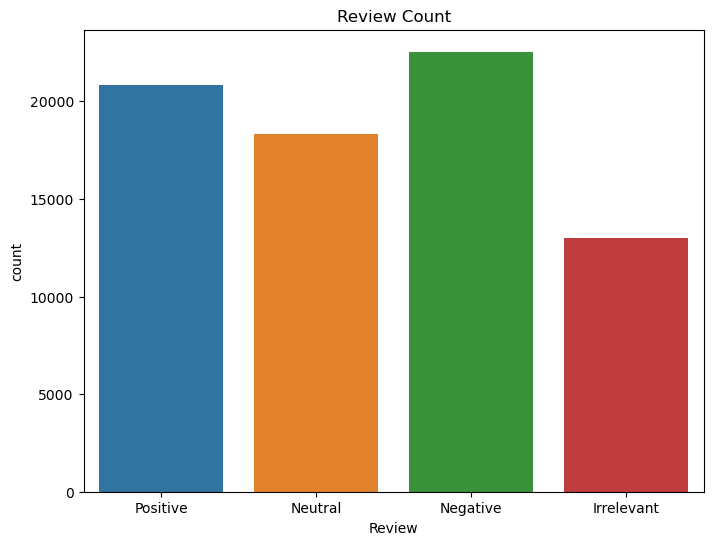

In [17]:
#EDA
import seaborn as sns
import matplotlib.pyplot as plt

# Check data types and unique values
print(twitter['Review'].dtype)
print(twitter['Review'].unique())

# Create a count plot
plt.figure(figsize=(8, 6))
sns.countplot(data=twitter, x='Review')
plt.title('Review Count')
plt.xlabel('Review')
plt.show()

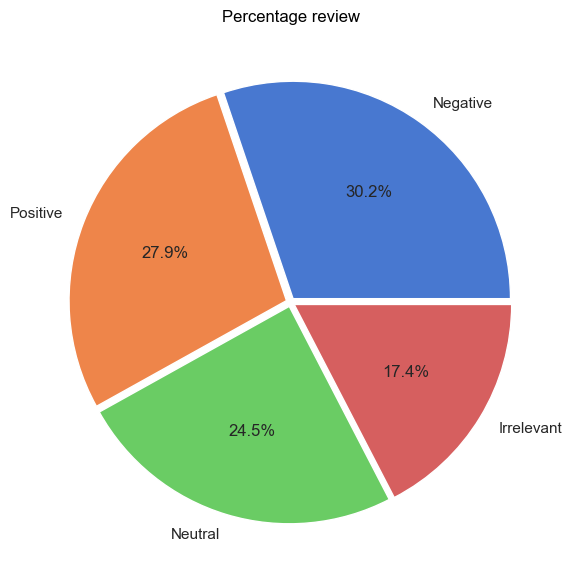

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

review_count = twitter['Review'].value_counts()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

sns.set_theme(style='ticks', palette='muted')
color = sns.color_palette(palette='muted')
explode = [0.02] * len(review_count)

axes.pie(review_count.values, labels=review_count.index, autopct='%1.1f%%', colors=color, explode=explode)
axes.set_title('Percentage review')

plt.tight_layout()
plt.show()

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RAJAN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RAJAN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


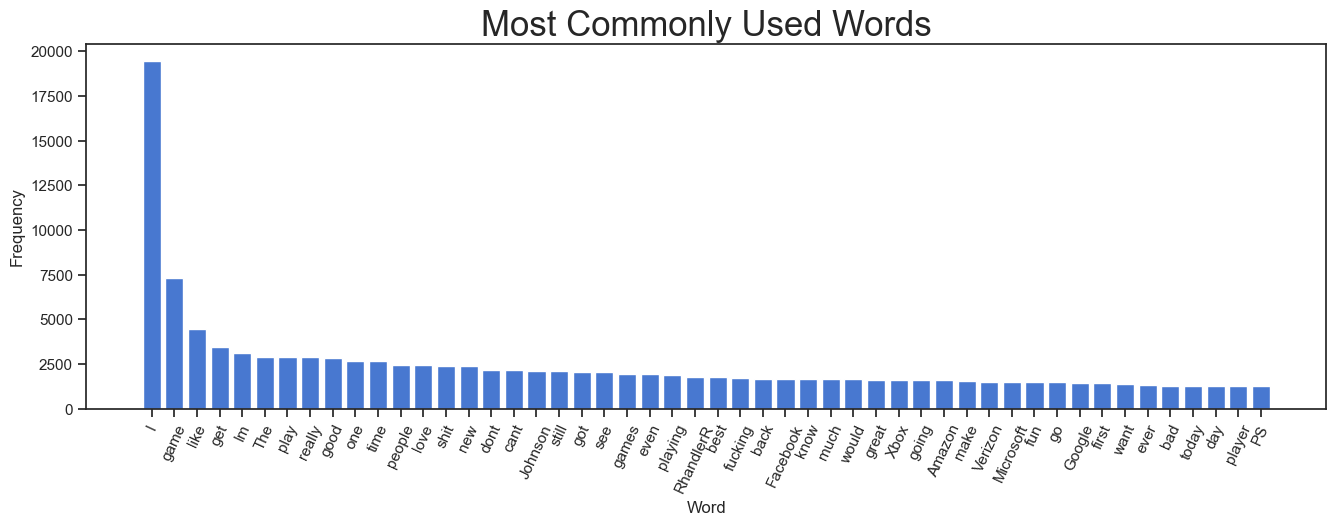

In [20]:
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from string import punctuation
from collections import Counter

# Download the 'stopwords' resource
nltk.download('stopwords')

def Most_Words_used(tweets, num_of_words):
    all_text = ''.join(twitter[tweets].values)
    
    all_text = re.sub('<.*?>', '', all_text)  # HTML tags
    all_text = re.sub(r'\d+', '', all_text)  # numbers
    all_text = re.sub(r'[^\w\s]', '', all_text)  # special characters
    all_text = re.sub(r'http\S+', '', all_text)  # URLs or web links
    all_text = re.sub(r'@\S+', '', all_text)  # mentions
    all_text = re.sub(r'#\S+', '', all_text)  # hashtags
    
    words = all_text.split() 
    
    # remove puncs 
    punc = list(punctuation) 
    words = [word for word in words if word not in punc]
    
    # remove stopwords (now that 'stopwords' is downloaded)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]
    
    word_counts = Counter(words)
    top_words = word_counts.most_common(num_of_words)
    
    return top_words

top_words = Most_Words_used('tweets', 50)

xaxis = [word[0] for word in top_words]
yaxis = [word[1] for word in top_words]

plt.figure(figsize=(16, 5))
plt.bar(xaxis, yaxis)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words', fontsize=25)
plt.xticks(rotation=65)
plt.subplots_adjust(bottom=0.15)
plt.show()

In [21]:
#Data Preprocessing
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RAJAN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
import nltk.data

print(nltk.data.path)

['C:\\Users\\RAJAN/nltk_data', 'C:\\Users\\RAJAN\\anaconda\\nltk_data', 'C:\\Users\\RAJAN\\anaconda\\share\\nltk_data', 'C:\\Users\\RAJAN\\anaconda\\lib\\nltk_data', 'C:\\Users\\RAJAN\\AppData\\Roaming\\nltk_data', 'C:\\nltk_data', 'D:\\nltk_data', 'E:\\nltk_data']


In [23]:
import nltk
import pandas as pd

# Specify the data directory explicitly
nltk.data.path.append("F:\\Internships\\ProdigyInfotech")

# Download the 'punkt' and 'wordnet' resources if not already downloaded
nltk.download('punkt')
nltk.download('wordnet')

# Define your DataPrep function
def DataPrep(text):
    # Your existing code for text preprocessing here
    
    # Tokenization
    tokens = nltk.word_tokenize(text)
    
    # Remove punctuation, stopwords, and perform lemmatization (assuming 'lemma' is defined)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    words = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    words = [lemma.lemmatize(word) for word in words]

    # Join the cleaned words back into a text
    cleaned_text = ' '.join(words)
    
    return cleaned_text


# asssuming a dataframe "twitter" with column "tweets"
twitter['cleaned_tweets'] = twitter['tweets'].apply(DataPrep)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RAJAN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RAJAN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
print(f'There are around {int(twitter["cleaned_tweets"].duplicated().sum())} duplicated tweets, we will remove them.')


There are around 13946 duplicated tweets, we will remove them.


In [25]:
twitter.drop_duplicates("cleaned_tweets", inplace=True)

In [26]:
twitter['tweet_len'] = [len(text.split()) for text in twitter.cleaned_tweets]

In [27]:
twitter = twitter[twitter['tweet_len'] < twitter['tweet_len'].quantile(0.995)]

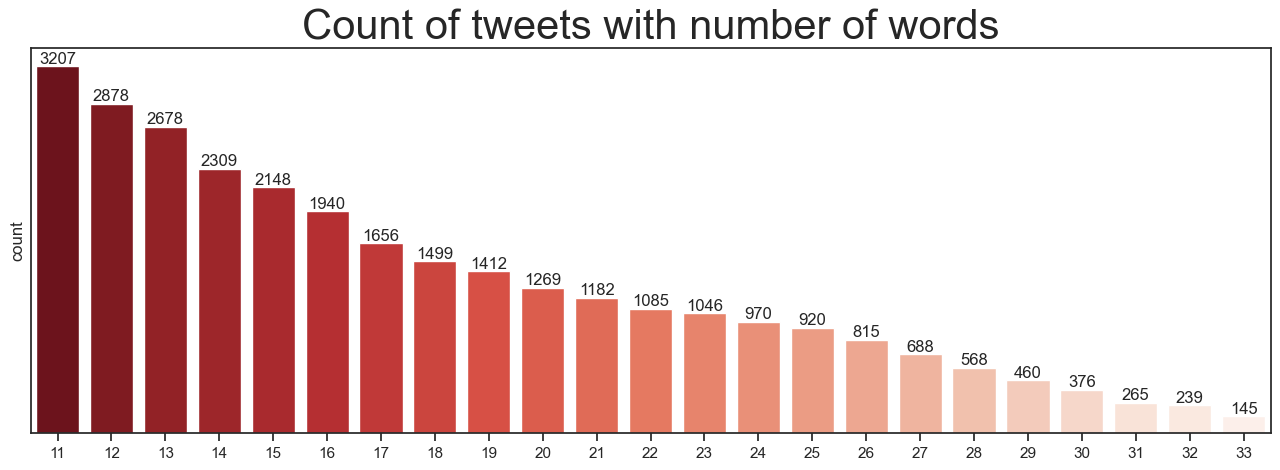

In [28]:
plt.figure(figsize=(16,5))
AX = sns.countplot(x='tweet_len', data=twitter[(twitter['tweet_len']<=1000) & (twitter['tweet_len']>10)], palette="Reds_r")
plt.title('Count of tweets with number of words', fontsize=30)
plt.yticks([])
AX.bar_label(AX.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [29]:
#splitting data into train and test part
from sklearn.model_selection import train_test_split

# Split your data into training and validation sets
x_train, x_test, y_train, y_test = train_test_split(twitter['cleaned_tweets'], twitter['Review'], train_size=0.85, random_state=42)


In [30]:
len(x_train) ,len(x_test)

(51290, 9052)

In [31]:
##extracting features
from sklearn.feature_extraction.text import TfidfVectorizer

vector = TfidfVectorizer()
vector.fit(x_train)

# Get the feature names
Feature_Names = vector.get_feature_names_out()

print("number of feature words: ", len(Feature_Names))

number of feature words:  22361


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Converting text data to lowercase before vectorization
x_train = [text.lower() for text in x_train]

# Creating vectorsizer
vector = TfidfVectorizer()

# Transforming lowercase text data
x_train = vector.fit_transform(x_train)  

# Transforming testing data in same manner
x_test = [text.lower() for text in x_test]
x_test = vector.transform(x_test)

In [33]:
#Encoding data
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

In [34]:
#Performing Logistic Regression
from sklearn.linear_model import LogisticRegression


LR = LogisticRegression(random_state=42)

# Fit the model to your training data
LR.fit(x_train, y_train)

LogisticRegression(random_state=42)

In [35]:
Train_Accuracy = LR.score(x_train , y_train)

In [36]:
LR_Predicted = LR.predict(x_test)

Test_Accuracy = accuracy_score(y_test , LR_Predicted) 

Test_Precision = precision_score(y_test , LR_Predicted , average='weighted')
Test_Recall = recall_score(y_test , LR_Predicted , average='weighted')
Test_F1score = f1_score(y_test , LR_Predicted , average='weighted')

In [37]:
print(f"The training accuracy for logistic regression : {(Train_Accuracy*100):0.2f}%\n")
print(f"The testing accuracy for logistic regression : {(Test_Accuracy*100):0.2f}%\n")
print(f"The precision for logistic regression : {Test_Precision:0.2f}\n")
print(f"The recall for logistic regression : {Test_Recall:0.2f}\n")
print(f"The F1 score for logistic regression : {Test_F1score:0.2f}\n")


The training accuracy for logistic regression : 82.57%

The testing accuracy for logistic regression : 74.93%

The precision for logistic regression : 0.75

The recall for logistic regression : 0.75

The F1 score for logistic regression : 0.75



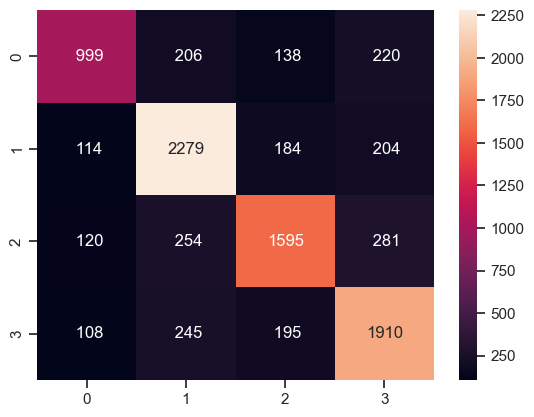

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

LR_Confusion_Matrix = confusion_matrix(y_test , LR_Predicted)
sns.heatmap(LR_Confusion_Matrix, annot=True,fmt='4g')
plt.show()

In [39]:
#Random Forest
# Performing random forest classifier
RF = RandomForestClassifier()
RF.fit(x_train , y_train)

RandomForestClassifier()

In [40]:
Train_Accuracy1 = RF.score(x_train , y_train)

In [41]:
RF_Predicted = RF.predict(x_test)

Test_Accuracy1 = accuracy_score(y_test , RF_Predicted) 

Test_Precision1 = precision_score(y_test , RF_Predicted , average='weighted')
Test_Recall1 = recall_score(y_test , RF_Predicted , average='weighted')
Test_F1score1 = f1_score(y_test , RF_Predicted , average='weighted')

In [42]:
print(f"The training accuracy for Random Forest : {(Train_Accuracy1*100):0.2f}%\n")
print(f"The testing accuracy for Random Forest : {(Test_Accuracy1*100):0.2f}%\n")
print(f"The precision for Random Forest : {Test_Precision1:0.2f}\n")
print(f"The recall for Random Forest : {Test_Recall1:0.2f}\n")
print(f"The f1 score for Random Forest : {Test_F1score1:0.2f}\n")

The training accuracy for Random Forest : 99.94%

The testing accuracy for Random Forest : 93.22%

The precision for Random Forest : 0.93

The recall for Random Forest : 0.93

The f1 score for Random Forest : 0.93



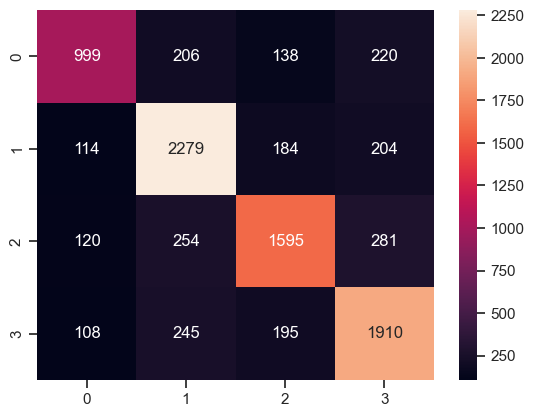

In [43]:
RF_CM = confusion_matrix(y_test , RF_Predicted)
sns.heatmap(LR_Confusion_Matrix, annot=True,fmt='3g')
plt.show()

In [44]:
#lSTM - Long Short-term Memory Networks
Max_Length = np.max(twitter['tweet_len'])
Max_Length

33

In [45]:
def lstm_prep(column , seq_len) : 
    # create a vocab of words 
    corpus = [word for text in column for word in text.split()]
    words_count = Counter(corpus) 
    sorted_words = words_count.most_common()
    vocab_to_int = {w:i+1 for i , (w,c) in enumerate(sorted_words)}
    
    text_int = [] 
    
    for text in column : 
        token = [vocab_to_int[word] for word in text.split()]
        text_int.append(token)
        
        
    # padding 
    features = np.zeros((len(text_int) , seq_len) , dtype = int)
    for idx , y in tqdm(enumerate(text_int)) : 
        if len(y) <= seq_len : 
            zeros = list(np.zeros(seq_len - len(y)))
            new = zeros + y
            
        else : 
            new = y[:seq_len]
            
        features[idx,:] = np.array(new)
        
    return sorted_words, features

In [46]:
VOCAB , tokenized_column = lstm_prep(twitter['cleaned_tweets'] , Max_Length)

0it [00:00, ?it/s]

In [47]:
VOCAB[:10]

[('game', 9398),
 ('johnson', 6619),
 ('like', 4491),
 ('get', 3983),
 ('facebook', 3846),
 ('xbox', 3756),
 ('google', 3756),
 ('microsoft', 3744),
 ('verizon', 3697),
 ('amazon', 3695)]

In [48]:
len(VOCAB)

23350

In [49]:
tokenized_column.shape

(60342, 33)

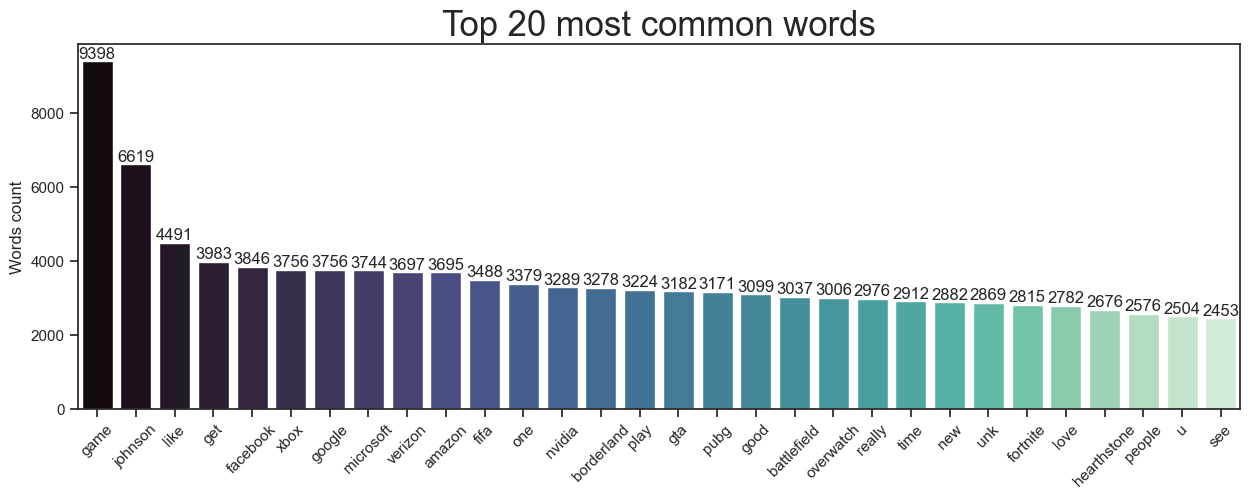

In [50]:
def most_common_words(vocab):
    keys = []
    values = []
    
    # Unpack the keys and values from the vocab list of tuples
    for key, value in vocab[:30]:
        keys.append(key)
        values.append(value)
        
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=keys, y=values, palette='mako')
    plt.title('Top 20 most common words', size=25)
    ax.bar_label(ax.containers[0])
    plt.ylabel("Words count")
    plt.xticks(rotation=45)
    plt.subplots_adjust(bottom=0.15)
    plt.show()

most_common_words(VOCAB)

In [51]:
X = tokenized_column
y = lb.fit_transform(twitter['Review'].values)

In [52]:
X_train , X_test , Y_train , Y_test = train_test_split(X , y , train_size=0.85 , random_state=42)


In [53]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.LongTensor(Y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.LongTensor(Y_test))

In [54]:
BATCH_SIZE = 64

In [55]:
torch.manual_seed(42)
train_dataloader = DataLoader(
    dataset = train_data , 
    batch_size=BATCH_SIZE , 
    shuffle=True
)

In [56]:
torch.manual_seed(42) 
val_dataloader = DataLoader(
    dataset = test_data , 
    batch_size = BATCH_SIZE , 
    shuffle=False
)

In [57]:
print(f"the size of the train dataloader {len(train_dataloader)} batches of {BATCH_SIZE}")

the size of the train dataloader 802 batches of 64


In [58]:
print(f"the size of the test dataloader {len(test_dataloader)} batches of {BATCH_SIZE}")

the size of the validation dataloader 142 batches of 64


In [59]:
EMBEDDING_DIM = 200

In [60]:
Word2vec_train_data = list(map(lambda x: x.split(), twitter['cleaned_tweets']))

In [61]:
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

In [62]:
def weight_matrix(model,vocab):
    vocab_size= len(vocab)+1
    embedding_matrix = np.zeros((vocab_size,EMBEDDING_DIM))
    for word, token in vocab:
        if model.wv.__contains__(word):
            embedding_matrix[token]=model.wv.__getitem__(word)
    return embedding_matrix

In [63]:
embedding_vec = weight_matrix(word2vec_model,VOCAB)
print("Embedding Matrix Shape:", embedding_vec.shape)

Embedding Matrix Shape: (23351, 200)


In [64]:
def param_count(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print('The Total number of parameters in the model : ', sum(params))

In [65]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_layers, hidden_dim, out_channels, bidirectional):
        super().__init__()

        self.no_layers = num_layers
        self.hidden_dim = hidden_dim
        self.out_channels = out_channels
        self.num_directions = 2 if bidirectional else 1
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers,
            dropout=0.5,
            bidirectional=bidirectional,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_dim * self.num_directions, out_channels)

    def forward(self, x):
        h0 = torch.zeros((self.no_layers * self.num_directions, x.size(0), self.hidden_dim))
        c0 = torch.zeros((self.no_layers * self.num_directions, x.size(0), self.hidden_dim))

        embedded = self.embedding(x)

        out, _ = self.lstm(embedded, (h0, c0))

        out = out[:, -1, :]

        out = self.fc(out)

        return out

In [66]:
# define parameters 
VOCAB_SIZE = len(VOCAB) + 1
NUM_LAYERS = 2 
OUT_CHANNELS = 4 
HIDDEN_DIM = 256
BIDIRECTIONAL = True

model = LSTM(VOCAB_SIZE , EMBEDDING_DIM , NUM_LAYERS , HIDDEN_DIM , OUT_CHANNELS , BIDIRECTIONAL)

model.embedding.weight.data.copy_(torch.from_numpy(embedding_vec))

model.embedding.weight.requires_grad = True

In [67]:
param_count(model)

The Total number of parameters in the model :  7187196


In [68]:
criterion=nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(),lr=0.001)

In [69]:
epochs = 10 
training_loss = []
training_acc = [] 
for i in tqdm(range(epochs)) : 
    epoch_loss = 0
    epoch_acc = 0 
    for batch , (x_train , y_train) in enumerate(train_dataloader) : 
        y_pred = model(x_train)
        
        loss = criterion(y_pred , y_train) 
        
        if batch % 500 == 0:
            print(f"Looked at {batch * len(x_train)}/{len(train_dataloader.dataset)} samples.")
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_loss +=loss 
        epoch_acc += accuracy_score(y_train , y_pred.argmax(dim=1))
        
    training_loss.append((epoch_loss/len(train_dataloader)).detach().numpy())
    training_acc.append(epoch_acc/len(train_dataloader))
    
    print(f"Epoch {i+1}: Accuracy: {(epoch_acc/len(train_dataloader)) * 100}, Loss: {(epoch_loss/len(train_dataloader))}\n\n")

  0%|          | 0/10 [00:00<?, ?it/s]

Looked at 0/51290 samples.
Looked at 32000/51290 samples.
Epoch 1: Accuracy: 60.9273091310186, Loss: 0.9476717114448547


Looked at 0/51290 samples.
Looked at 32000/51290 samples.
Epoch 2: Accuracy: 83.78093228467293, Loss: 0.4525495171546936


Looked at 0/51290 samples.
Looked at 32000/51290 samples.
Epoch 3: Accuracy: 90.03183147899482, Loss: 0.2826705574989319


Looked at 0/51290 samples.
Looked at 32000/51290 samples.
Epoch 4: Accuracy: 92.87238634183771, Loss: 0.20142841339111328


Looked at 0/51290 samples.
Looked at 32000/51290 samples.
Epoch 5: Accuracy: 94.29161471321696, Loss: 0.15704721212387085


Looked at 0/51290 samples.
Looked at 32000/51290 samples.
Epoch 6: Accuracy: 95.25989713216958, Loss: 0.13132302463054657


Looked at 0/51290 samples.
Looked at 32000/51290 samples.
Epoch 7: Accuracy: 96.08805510262805, Loss: 0.10999215394258499


Looked at 0/51290 samples.
Looked at 32000/51290 samples.
Epoch 8: Accuracy: 96.54379675810473, Loss: 0.09546495229005814


Looked at 0/

In [70]:
print(f"The loss of the training set is : {training_loss[-1]:0.2f}")
print(f"The accuracy of the training set is : {(training_acc[-1]*100):0.2f}%")

The loss of the training set is : 0.07
The accuracy of the training set is : 97.35%


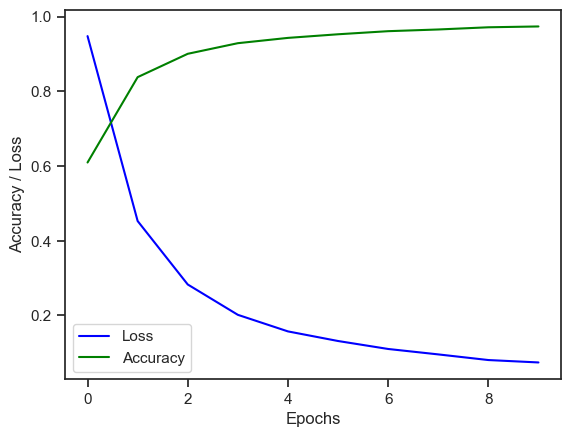

In [71]:
plt.plot(range(epochs),training_loss,color="blue",label="Loss")
plt.plot(range(epochs),training_acc,color="green",label="Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.show()

In [72]:
val_loss=0
val_acc3= 0
lstm_preds=[]
val_targets = []
torch.manual_seed(42)
with torch.no_grad() : 
        for x_val , y_val in tqdm(val_dataloader) : 
            y_pred=model.forward(x_val)
            val_pred = torch.softmax(y_pred , dim=1 ).argmax(dim=1)
            lstm_preds.append(val_pred)
            val_targets.extend(y_val)
            
            loss=criterion(y_pred,y_val)
            val_loss+=loss
            val_acc3 += accuracy_score(y_val , y_pred.argmax(dim=1))
            
            
val_loss/=len(val_dataloader)
val_acc3/=len(val_dataloader)
lstm_preds = torch.cat(lstm_preds)
val_targets = torch.Tensor(val_targets)

  0%|          | 0/142 [00:00<?, ?it/s]

In [73]:
train_acc3 = training_acc[-1]
val_precision3 = precision_score(val_targets,lstm_preds,average='weighted')
val_recall3 = recall_score(val_targets,lstm_preds,average='weighted')
val_f1score3 = f1_score(val_targets,lstm_preds,average='weighted')


In [74]:
print(f"The training accuracy for LSTM : {(train_acc3*100):0.2f}%\n")
print(f"The validation accuracy for LSTM : {(val_acc3*100):0.2f}%\n")
print(f"The precision for LSTM : {val_precision3:0.2f}\n")
print(f"The recall for LSTM : {val_recall3:0.2f}\n")
print(f"The f1 score for LSTM : {val_f1score3:0.2f}\n")
print(f"The training loss for LSTM : {training_loss[-1]:0.2f}\n")
print(f"The validation loss for LSTM : {val_loss:0.2f}\n")

The training accuracy for LSTM : 97.35%

The validation accuracy for LSTM : 86.36%

The precision for LSTM : 0.86

The recall for LSTM : 0.86

The f1 score for LSTM : 0.86

The training loss for LSTM : 0.07

The validation loss for LSTM : 0.61



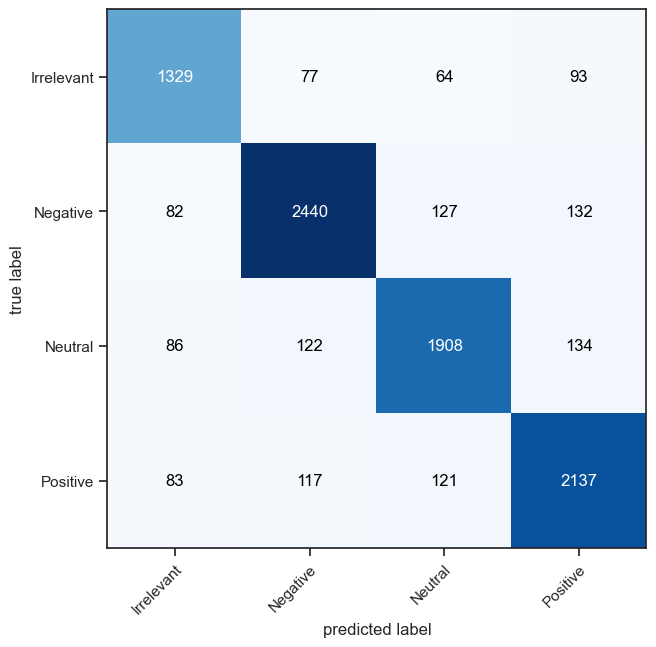

In [80]:
confmat = ConfusionMatrix(num_classes=4, task='multiclass')
confmat_tensor = confmat(preds=lstm_preds,
                         target=val_targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=twitter_review.keys(),
    figsize=(10, 7)
)

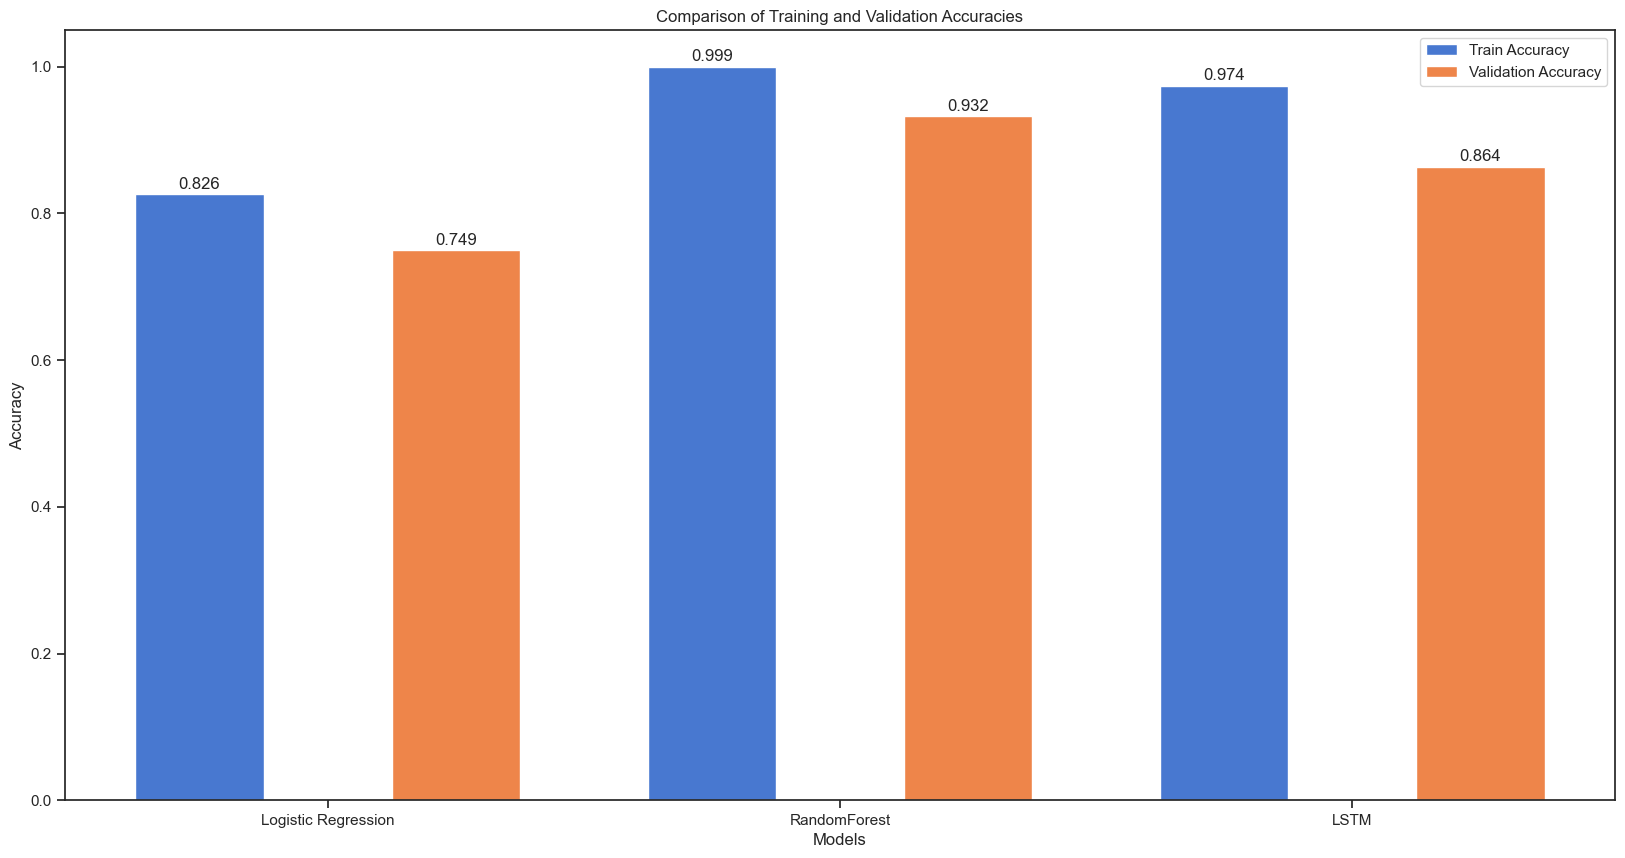

In [82]:
#Comparison Between Models
train_scores=[Train_Accuracy,Train_Accuracy1,train_acc3]
val_scores=[Test_Accuracy,Test_Accuracy1,val_acc3]

models = ['Logistic Regression','RandomForest','LSTM']

x = np.arange(len(models))

width = 0.25

fig, ax = plt.subplots(figsize=(20, 10))

rects1 = ax.bar(x - width, train_scores, width, label='Train Accuracy')

rects2 = ax.bar(x + width, val_scores, width, label='Validation Accuracy')

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Training and Validation Accuracies')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

In [85]:
#making predictions
test_twitter = pd.read_csv("F:\\Internships\\ProdigyInfotech\\twitter_validation.csv")

In [86]:
test_twitter.columns

Index(['3364', 'Facebook', 'Irrelevant',
       'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣'],
      dtype='object')

In [87]:
test_twitter = test_twitter.drop('3364' , axis=1)

In [88]:
test_twitter = test_twitter.rename(columns={"Facebook":"Feature2","I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣":"Feature1","Irrelevant": "labels"})


In [89]:
test_twitter["tweets"]= test_twitter["Feature1"].astype(str) +" "+ test_twitter["Feature2"].astype(str)
test_twiter = test_twitter.drop(["Feature1","Feature2"],axis=1)


In [90]:
test_twitter.head()

,Feature2,labels,Feature1,tweets
0,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,@Microsoft Why do I pay for WORD when it funct...
2,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...","CSGO matchmaking is so full of closet hacking,..."
3,Google,Neutral,Now the President is slapping Americans in the...,Now the President is slapping Americans in the...
4,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [108]:
# Define the twitter_Review dictionary
twitter_Review = {
    'Positive': 0,
    'Neutral': 1,
    'Negative': 2,
   
}

In [109]:
def getlabel(n):
    for label, code in twitter_Review.items():
        if code == n:
            return label

In [110]:
label = getlabel(1)

In [111]:
import torch
from tqdm import tqdm

def make_predictions(row):
    random_data = row.sample(n=10)
    random_tweets = random_data['tweets'].values

    cleaned_tweets = [] 
    for tweet in random_tweets:
        cleaned_tweets.append(DataPrep(tweet))
        
    x_test = vector.transform(cleaned_tweets).toarray()
    y_test = random_data['labels'].values

    lr_pred = LR.predict(x_test)
    rf_pred = RF.predict(x_test)

    _, X_test = lstm_prep(cleaned_tweets, Max_Length)
    X_test = torch.from_numpy(X_test)

    lstm_pred = model(X_test)
    lstm_pred = torch.softmax(lstm_pred, dim=1).argmax(dim=1)

    for i in tqdm(range(10)):
        print(f"The original tweet: {random_tweets[i]}\n")
        print(f"The original label: {y_test[i]}\n")
        print(f"The lr prediction is: {getlabel(lr_pred[i])}\n")
        print(f"The rf prediction is: {getlabel(rf_pred[i])}\n")
        print(f"The lstm prediction is: {getlabel(lstm_pred[i])}\n")
        print('-' * 120)

# Call the function with your data
make_predictions(test_twitter)

10it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 52.02it/s]

The original tweet: Back at the OG memes... I love the sky base, follow me every day @Cyper for everyday content. #Fortnite #meme #MEMES #lmao #omg #gaming https://t.co/wROS35dZyA Fortnite

The original label: Irrelevant

The lr prediction is: Positive

The rf prediction is: Positive

The lstm prediction is: None

------------------------------------------------------------------------------------------------------------------------
The original tweet: @Rainbow6Game @SpearheadBeer best combination for enjoying the Pro-leagues before I head to Montreal to see the finals live. pic.twitter.com/O5gX0vf2Gz TomClancysRainbowSix

The original label: Neutral

The lr prediction is: Negative

The rf prediction is: Negative

The lstm prediction is: Positive

------------------------------------------------------------------------------------------------------------------------
The original tweet: Yuumi - super cool fucking cat
Braum - such a good person
Neeko - damn funny
Janna - she would take g